# <u>Chapter 3: Modelling Kepler lightcurves - Toolbox

<div class="alert alert-block alert-info">
    
This notebook contains tools you will need to model your lightcurve, it is not a guided notebook like previous notebook, but instead introduces you to tools you'll need to find your planet properties. I recommend copying relevant code across to a separate notbook to do your fitting.

#### In this notebook, you find tools to:

- reduce the lightcurve to create a single corrected lightcurve, this will need to be included in your submission. 
- create a periodogram to identify the periods of different planets
- fit the depth of a specific transit or your choosing, results with errors need to be included in the submission
- fold the lightcurve for the same planet, finished stacked transits needs to be included in your submission

### Table of content

- [1. IO](#sec:io)
- [2. Filtering/Smoothing](#sec:filtering)
- [3. Fitting](#sec:fitting)
- [4. Masking](#sec:masking)
- [5. Periodicities](#sec:period)
- [6. Folding](#sec:folding)

In [1]:
from astropy.io import fits #used to open fits files in which data are stored
import matplotlib.pyplot as plt #plotting
import glob
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit
import LightCurveSimulator

<a id="sec:io"></a>
## 1. Input/Output: Writing data to file, reading data

In this section, you will be manipulating datasets, you might want to write the data to file for future use. There are two ways of doing this. Python file manipulation and numpy.

### 1.1 IO: Python File manipulation. 
The most general way for working with files. See [official documentation](https://docs.python.org/3/library/functions.html#open). Check out [strong formatting here](https://www.learnpython.org/en/String_Formatting).

In [ ]:
## Lets open a file, the first argument is the filename, the second is the mode 'r' for read-only, 'w' for write
filehandle = open('STUPIDTESTFILE', 'w')
filehandle.write('Hello world \n') #'\n' adds a line break
filehandle.write('%s, %s, %s \n' %(1,2,3)) #
filehandle.write('This is what happens if you do not add a line break')
filehandle.write('14, 15, 16')
filehandle.close()

In [ ]:
#### Have a look at the file in your main tab. You can open this file as follows.
filehandle = open('STUPIDTESTFILE', 'r')
filehandle.readlines()

### 1.2 IO: numpy file manipulation
You can get more specialized file manipulation with [numpy.loadtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) and [numpy.savetxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html). This function works specifically for arrays, if you have more general data, the method above works better.

In [ ]:
#### Lets say we have an array and want to write it to file.
t = [1,2,3,4,5,6,7,8,9,10]
flux = [1,1,0.9,0.9,0.9, 0.9,1,1,1 ,1]
np.savetxt('NUMPYTESTFILE', np.array([t, flux]).transpose(), delimiter=',') #delimiter sets the sign used between fields, ',' is a commonly used one
#transpose turns this into a standatd two column file, have a look in your browser

In [ ]:
# We can now load the same file
testdata = np.loadtxt('NUMPYTESTFILE', delimiter=',') ## rememberto give the delimiter
plt.plot(testdata[:,0], testdata[:, 1])

<a id="sec:filtering"></a>
## 2. Filtering and smoothing data - non-parametric models

In some cases, you might need to filter your dataset. This might be because of extreme outliers, as you encountered in LightCurveSimu, because of cosmic rays in imaging data or because there is actual signal on short time or spatial scales that needs to be removed for analysis. There are many such methods available, we will outline a few general classes here.

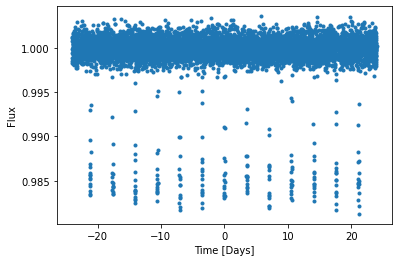

In [2]:
# Lets create a lightcurve with outliers for our smoothing
lc = LightCurveSimulator.LongLightcurve()
lc.add_noise(1000)
#lc.add_outliers(0.1, 0.1)
lc.plotlc()
t, f, e = lc.getdata()

### 2.1 Filtering/Smoothing: Savitzky-Golay

This is a kind of filter that fits polynomials locally to the data. It can be used to smooth data. See the [scipy implimentation](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html).

In [9]:
from scipy.signal import savgol_filter
interp_savgol = savgol_filter(f, window_length=1001, polyorder=3)
#windowlength is the length of the window over which the polynomial will be fit, polyorder is the order of the polynimial to be fit

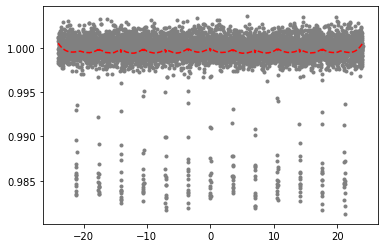

In [10]:
plt.plot(t, f, ls='None', marker='.', c='grey', label='Data')
plt.plot(t, interp_savgol, ls='--', c='r', label='Savitzky Golay w=11,o=3')

This now shows a curve that describes the overall shape of the lightcurve. You will see that if the window length is too short, the smoothing "follows" the transit, so once you divide by it, the transit is partually removed. Watch out for this in your analysis.

In [ ]:
plt.plot(t, f/interp_savgol)

### 2.2 Filtering/Smoothing: Splines

[Splines](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BSpline.html) are commonly used to interpolate data. They allow you to describe data in ranges not covered by the data itself (in case of gaps...). Here, we feed the time, flux as well as the degree of the data.

In the first application, we see spline applied to the full datasets, as you see, the spline will fit through the data points. It is therefore not necessarily useful when trying to smooth well sampled data since it renoves also the short timescale trends we are interested in.

In [ ]:
tnew = np.arange(-20, 20, 0.001)
newfl = interpolate.BSpline(t, f, 2, extrapolate=True)
plt.plot(t, f, ls='None', marker='.', c='grey', label='Data')
plt.plot(tnew, newfl(tnew), ls='--', c='r', label='Spline')
plt.legend()

Intstead, splines can be useful for interpolating over gaps, see below.

In [ ]:
lc_clean = LightCurveSimulator.ShortTransit()
lc_clean.add_noise(10000)
t_c, f_c, e_c = lc_clean.getdata()
m = ~((t_c> -0.05) & (t_c < -0.047 )) #creating a gap in the data an the beggining of the transit
tnew = np.arange(-0.12, 0.12, 0.001)
newfl_sp = interpolate.BSpline(t_c[m], f_c[m], 2, extrapolate=True)
plt.plot(t_c, f_c, ls='None', marker='.', c='grey', label='Full Data', ms=2)
plt.plot(t_c[m], f_c[m], ls='None', marker='.', c='b', label='Data used for Spline')
plt.plot(tnew, newfl_sp(tnew), ls='--', c='r', label='Spline')

### 2.3: Filtering/Smoothing: Median filters

The median filter can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html). Example code is shown below. This can be used in the presence of strong outliers in the dataset.

In [11]:
from scipy.signal import medfilt

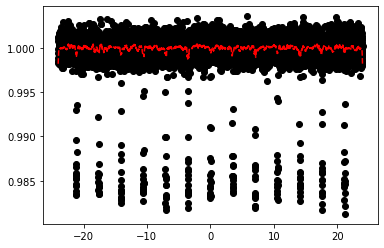

In [14]:
testfil = medfilt(f, kernel_size=51) ##kernel_size is the size of the window over which the median is calculated 
plt.plot(t, f, c='k', ls='None', marker='o', label='Data')
plt.plot(t, testfil, ls='--', c='r', label='Median Filter')

As before, if the window length is too short, the transits will be removed. You do NOT want the smoothing to follow the transit dips.

<a id="sec:fitting"></a>
## 3. Model Fitting

### 3.1 Least square fitting
You can use [scipy.otimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) for fitting data. It works as follows:

In [ ]:
#First, define a function, the x value needs to be the first parameter to the function
#the function needs to return f(x)
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [ ]:
### Create some test data to fit
xdata = np.linspace(0, 4, 50) #getting the x values
y = func(xdata, 2.5, 1.3, 0.5) #getting the x values
y_noise = 0.2 * np.random.normal(size=xdata.size) #adding some noise
ydata = y + y_noise
yerror = np.ones_like(xdata) * 0.2 #this was the uncertainty 
plt.plot(xdata, ydata, 'b-', label='data')

In [ ]:
##Now fit the data. 
popt, pcov = curve_fit(func, xdata, ydata, sigma=yerror, p0=[1,2,3])

#### Note: You can also pass the curve_fit function a starting value as p0=[1,2,3]. This may be useful if you suspect being stuck in a local minimum.

In [ ]:
##popt is your best fit
popt

In [ ]:
#pcov is the covariance matric
pcov

In [ ]:
#The square root of the diagonal is the uncertainty on the fit
np.sqrt(np.diag(pcov))

In [ ]:
#plotting everything
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'g--',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

### 3.2 Residuals

Once we have performed a fit, inspecting the residuals can be extremely useful to see regions in which the model does not fit the data well. If you spot any clear structure in the residual, that can be a sign that you need to increase the complexeity of your model.

In [ ]:
plt.plot(xdata, ydata-func(xdata, *popt))

### 3.3 Calculating chi-squared - assessing goodness of fit

We have learned that calculating chi-squared is used to measure the goodness of fit and compare models. Below is a function for you.

In [ ]:
def chisquared(y, error, ymodel):
    return np.sum((y-ymodel)**2/error**2)

chisquared(ydata, yerror, func(xdata, *popt)) / (len(xdata) - 3 -1)

In [ ]:
##Let's try this out on our model fit.
chisquared(ydata, yerror, func(xdata, *popt))

What is our degree of freedom $\nu$? This is the number of data points minus number of free paramaters in the fit - 1:

In [ ]:
len(xdata) - 3 - 1 ## number of data points

In [ ]:
### Therefore, the reduced chi-squared is:
chisquared(ydata, yerror, func(xdata, *popt)) / (len(xdata) - 3 -1)

### 3.4 Polynomial fit

If you want to fit a polynonial, python has a custom function [numpy.polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)

<a id="sec:masking"></a>
## 4. Masking arrays - dealing with outliers and working with parts of arrays

In some cases, you might want to consider only a subset of the data. Some code is given below.

In [ ]:
xtest = np.arange(50)
ytest = np.random.standard_normal(size=50)
plt.plot(xtest, ytest)

In [ ]:
## Choosing only the data between x=20-30
xmask2030 = (xtest > 20) & (xtest < 30)
plt.plot(xtest, ytest, c='k')
plt.plot(xtest[xmask2030], ytest[xmask2030], c='r')

In [ ]:
### Choosing only data where the y value is negative
yneg = (ytest < 0)
plt.plot(xtest, ytest, c='k')
plt.plot(xtest[yneg], ytest[yneg], c='r', ls='None', marker='o')

<a id="sec:period"></a>
## 5. Identifying periodicities

There are a number of functions to identify periodicties, we recommend [scipy.signal.lombscargle](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html#scipy.signal.lombscargle) which works also for unevenly sampled data. This of course is very common in astrophysics.

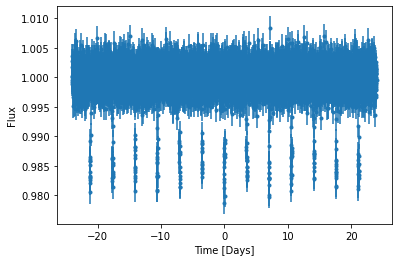

In [2]:
## Let's look at a long lightcurve with some error
lclong = LightCurveSimulator.LongLightcurve()
lclong.add_noise(sn=500)
lclong.plotlc_error()
t, f, e = lclong.getdata()

Click yourself to the [scipy.signal.lombscargle description](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html#scipy.signal.lombscargle). You will see that we will need the frequencies. We have the time on the y-axis, of ~50 (days), with the shortest samplin of:  

In [3]:
t[1] - t[0]

0.0069444444961845875

In [4]:
t[-1]-t[0]

47.993055913131684

Let's get a periodogram to cover this range of timescales. Therefore, our frequencies are:

In [22]:
freqs = np.linspace((1/45.),(1/0.007), 1000)
import scipy.signal
from scipy.signal import lombscargle
lomb = scipy.signal.lombscargle(t, f, freqs, precenter=True)

Text(0, 0.5, 'Power')

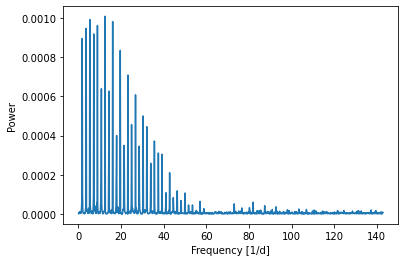

In [23]:
plt.plot(freqs, lomb)
plt.xlabel('Frequency [1/d]')
plt.ylabel('Power')

What happened?

Text(0, 0.5, 'Power')

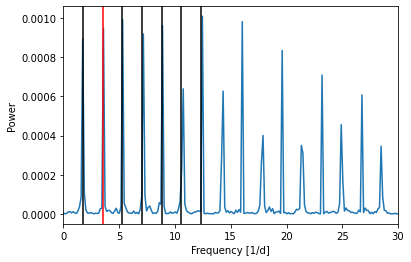

In [7]:
plt.plot(freqs, lomb)
plt.xlim(0,30)
actper = 3.52474859 ## the actual period
plt.axvline(actper, c='r') ## indicating the actual period
for i in [0.5, 1.5, 2, 2.5, 3,3.5]:
    plt.axvline(actper*i, c='k')
plt.xlabel('Frequency [1/d]')
plt.ylabel('Power')

This is known as aliasing, we will discuss the issues of interpreting such periodograms. A paper discussing it's meaning can be found [here](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract).

As you can see there are multiple peaks due to aliasing, this can be particularly tricky if there are multiple planets in the same system. Since the alisiaing creates a periodoc signal, a second lomb scargle can be used to filter the signal. This has a very limited effect in the artificially simple system shown here, but will come in handy for the more complex data you will be working with.

In [8]:
period = np.linspace(1,30, 10000)
lomb2 = scipy.signal.lombscargle(freqs, lomb, period, precenter=True)

Text(0, 0.5, 'Power')

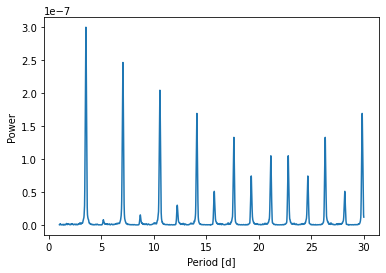

In [9]:
plt.plot(period, lomb2)
plt.xlabel('Period [d]')
plt.ylabel('Power')

<a id="sec:folding"></a>
## 6. Folding your lightcurve

If you have long lightcurves, you may have to fold them, i.e. shift them by the period so you can see a more detailed view of an individual transit. Below is some code to do so, modified from code provided by Victoria Scowcroft. This uses pandas DataFrames, whicch can be useful for manipulating datasets, see an introduction [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

In [10]:
def fold_lightcurve(time, flux, error, period):
    """
    Folds the lightcurve given a period.
    time: input time (same unit as period)
    flux: input flux
    error: input error
    period: period to be folded to, needs to same unit as time (i.e. days)
    returns: phase, folded flux, folded error
    """
    #Create a pandats dataframe from the 
    data = pd.DataFrame({'time': time, 'flux': flux, 'error': error})
    
    #create the phase 
    data['phase'] = data.apply(lambda x: ((x.time/ period) - np.floor(x.time / period)), axis=1)
    
    #Creates the out phase, flux and error
    phase_long = np.concatenate((data['phase'], data['phase'] + 1.0, data['phase'] + 2.0))
    flux_long = np.concatenate((flux, flux, flux))
    err_long = np.concatenate((error, error, error))
    
    return(phase_long, flux_long, err_long)

Let's fold our test lightcurve to the period of the system (of 3.52474859 days), by passing the time, flux and error and period. We can use the syntaxt below to store the output phase, folded flux and folded error.

In [17]:
p, p_flux,p_error = fold_lightcurve(t, f, e, 3.52)

We can now plot the folded lightcurve.

Text(0, 0.5, 'Flux')

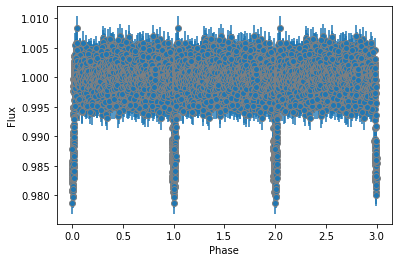

In [18]:
plt.errorbar(p, p_flux, yerr=p_error, marker='o', ls='None', zorder=4, label='_nolegend_', mec='Grey')
plt.xlabel('Phase')
plt.ylabel('Flux')

The transits have now been folded to the their period. There are folded transits and phase 0, 1, 2, 3, indicating that the lightcurve has been folded to the correct period. In this plot, on the x-axis, 1 phase is now 1 period. Folding the multiples of the actual period will result in transits in the lightcurve that are NOT separated by 1 phase. Keep this in mind when folding the lightcurve.

Here, transits are located at phase 0,1,2,3. A closer look at the transit is possible once the phase has been identified.

(0.9, 1.1)

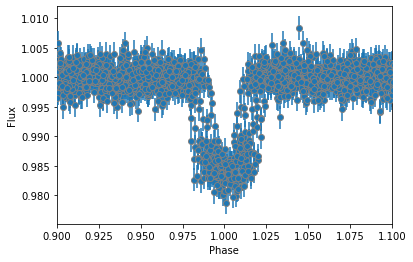

In [19]:
plt.errorbar(p, p_flux, yerr=p_error, marker='o', ls='None', zorder=4, label='_nolegend_', mec='Grey')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0.9, 1.1)

This transit has been folded extremely well, resulting in a single well defined transit, if the period is not determined correctly, the individual transits are less well aligned, resulting in a 'smeared' transit. Remember also that multiple planets might be present in your lightcurve that might be visible in the folded lightcurve.